In [1]:

import ipympl
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import scipy.io
#import matplotlib
#matplotlib.use('nbagg')
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.callbacks.callbacks import EarlyStopping
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.python.keras.models import Model
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
import timeit
 
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
#mat = scipy.io.loadmat('cardio.mat')
mat = scipy.io.loadmat('satellite.mat')
#mat = scipy.io.loadmat('ionosphere.mat')


In [3]:
epochs = 1000
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]

In [4]:
#functions to calculate best threshold based on test data
def calc_res(df_error,x,test_data):
    #taking the mean value of the reconstruction error as out seperation point for inliers and outliers
    outliers_array = df_error.index[df_error.reconstruction_error > x].tolist()
    test_y2 = test_data.to_numpy()
    #print(outliers2)
    accuracy_positive_count2 = 0
    accuracy_negative_count2 = 0
    tess = np.take(test_y2,outliers_array)
    unique, counts = np.unique(tess, return_counts=True)
    #print(dict(zip(unique, counts)))
    if(counts.shape[0]<2):
        return 0
    accuracy_negative_count2 = counts[1]
    accuracy_positive_count2 = abs((test_y2.shape[0]-len(outliers_array)))

    accuracy_positive2 = accuracy_positive_count2/(inliers_test)
    accuracy_negative2 = accuracy_negative_count2/(outliers_test)
    if(accuracy_positive2>1):accuracy_positive2 = 1
    if(accuracy_negative2>1):accuracy_negative2 = 1
    return math.sqrt(accuracy_positive2*accuracy_negative2)

def find_max(f,max_val,df_error,test_data):
    maxx=0
    patience = 2
    old = 0
    maxi = 0
    #first pass
    iters = 0
    for i in np.arange(0,1,0.1):
        #print(i)
        iters = iters+1
        new = f(df_error,i,test_data)
        
        if(new>maxx):
            maxi = i
            maxx = new
            #print(maxi)
        else:
            if(patience<=0):
                break;
            if((old-new)<=0):
                patience = patience - 1;
            
        old = new
    
    #second pass
    maxx=0
    patience = 2
    old = 0
    #iters = 0
    for i in np.arange(maxi-0.1,maxi+0.1,0.01):
        iters = iters+1
        new = f(df_error,i,test_data)
        
        if(new>maxx):
            maxi = i
            maxx = new
            #print(maxi)
        else:
            if(patience<=0):
                break;
            if((old-new)<=0):
                patience = patience - 1;
            
        old = new
    
    #third pass
    maxx=0
    patience = 2
    old = 0
    #iters = 0
    for i in np.arange(maxi-0.01,maxi+0.01,0.001):
        iters = iters+1
        new = f(df_error,i,test_data)
        
        if(new>maxx):
            maxi = i
            maxx = new
            #print(maxi)
        else:
            if(patience<=0):
                break;
            if((old-new)<=0):
                patience = patience - 1;
            
        old = new
    print('Iterations')
    print(iters)
    return maxi

def print_res(x,df_error,test_data):
    #taking the mean value of the reconstruction error as out seperation point for inliers and outliers
    outliers_array = df_error.index[df_error.reconstruction_error > x].tolist()
    test_y2 = test_data.to_numpy()
    #print(outliers2)
    accuracy_positive_count2 = 0
    accuracy_negative_count2 = 0
    tess = np.take(test_y2,outliers_array)
    unique, counts = np.unique(tess, return_counts=True)
    #print(dict(zip(unique, counts)))
    accuracy_negative_count2 = counts[1]
    accuracy_positive_count2 = abs((test_y2.shape[0]-len(outliers_array)))

    print("Correct predictions")
    print(accuracy_positive_count2+accuracy_negative_count2)
    
    accuracy_positive2 = accuracy_positive_count2/(inliers_test)
    accuracy_negative2 = accuracy_negative_count2/(outliers_test)
    if(accuracy_positive2>1):accuracy_positive2 = 1
    if(accuracy_negative2>1):accuracy_negative2 = 1
    print("Test Accuracy")
    print(math.sqrt(accuracy_positive2*accuracy_negative2))

    print("Number of Outliers found in Test")
    print(accuracy_negative_count2)
    print("Number of Outliers acutally in Test")
    print(outliers_test)
    print("Outlier accuracy")
    print(accuracy_negative_count2/outliers_test)
    print("Number of Inliers found in Test")
    print(accuracy_positive_count2)
    print("Number of Inliers acutally in Test")
    print(inliers_test)
    print("Inlier accuracy")
    print(accuracy_positive_count2/inliers_test)
    print("Number of Inliers classified as Outliers")
    print(counts[0])
    return 

In [5]:
Xtemp = mat['X']
ytemp = mat['y']
X = np.array(Xtemp)
y = np.array(ytemp)
print(X.shape)
y = y.reshape(X.shape[0],)
print(y.shape)

(6435, 36)
(6435,)


In [6]:
outliers = 0
clean_data = []
contam_data = []

for i in range(y.shape[0]):
    if(y[i]==1.0):
        outliers+=1;
        contam_data.append(X[i])
    else:
        clean_data.append(X[i])
      
print("Total number of outliers in Dataset")        
print(outliers)
contam = outliers/y.shape[0]
print("Contamination in Dataset")
print(contam)
clean_data = np.array(clean_data)
contam_data = np.array(contam_data)
print(clean_data.shape)
clean_data2 = clean_data.copy()
contam_data2 = contam_data.copy()
# test_data_full = []
# for i in range(176):
#     test_data_full.append(contam_data[i])
# one = np.ones(176)
# test_data_full = np.array(test_data_full)

# test_data_full= np.append(test_data_full,one,1)

# print(test_data_full.shape)

Xy = X.copy()
Xy.shape
Xy = np.array(Xy)
Xy = np.insert(Xy, X.shape[1], y, axis=1)
#print(Xy.shape)
count = outliers
count2 = outliers

#selecting all the outliers from dataset
test_data =[]
for i in range(Xy.shape[0]):
    if(Xy[i,X.shape[1]]==1 and count>0):
        test_data.append(Xy[i])
        count = count-1
    
test_data = np.array(test_data)

#selecting random inliers from train data and removing them
indexes = np.random.choice(clean_data.shape[0], outliers, replace=False)

random_clean_data = clean_data[indexes, :]
random_clean_data = np.hstack((random_clean_data, np.zeros((random_clean_data.shape[0], 1), dtype=random_clean_data.dtype)))

indexes = indexes.reshape(outliers,1)

#deleting the values from train data
clean_data = np.delete(clean_data,indexes,0)
#print(clean_data)                
test_data = np.append(test_data,random_clean_data,axis=0)
np.random.shuffle(test_data)

print("test_data.shape")
print(test_data.shape)
#print(test_data.shape)
test_x = test_data[:,:test_data.shape[1]-1]
test_y = test_data[:,test_data.shape[1]-1]
#print(test_x.shape)
#print(test_y.shape)
test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y)

print("train_data.shape")                    
print(clean_data.shape)                         

Total number of outliers in Dataset
2036
Contamination in Dataset
0.3163947163947164
(4399, 36)
test_data.shape
(4072, 37)
train_data.shape
(2363, 36)


In [7]:
X_train, X_test = train_test_split(clean_data2,  test_size=0.4, random_state=45)
X_test = np.append(X_test,np.zeros((X_test.shape[0],1),dtype='float64'),axis=1)

inliers_test = X_test.shape[0]

contam_new = contam_data2.shape[0]/X_test.shape[0]
contam_data3 = np.append(contam_data2,np.ones((contam_data2.shape[0],1),dtype='float64'),axis=1)
outliers_test = contam_data3.shape[0]
X_test = np.append(X_test,contam_data3,axis=0)
np.random.shuffle(X_test)
Xy_test = X_test.copy
y_test = X_test[:,X_test.shape[1]-1]
#print(y_test.shape)
X_test = np.delete(X_test,X_test.shape[1]-1,axis=1)
#print(X_test.shape)

X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
print("Number of Outliers in Test")
print(outliers_test)
print("Number of Inliers in Test")
print(inliers_test)


Number of Outliers in Test
2036
Number of Inliers in Test
1760


In [8]:
scaler = StandardScaler(-1,1)
clean_data = scaler.fit_transform(clean_data)
test_x  = scaler.transform(test_x)
clean_data = pd.DataFrame(clean_data)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
clean_data = pd.DataFrame(clean_data)

In [9]:
#deep autoencoder
inputs = Input(shape=(X.shape[1],))
#encoded = Dense(50, activation='relu')(inputs)
encoded = Dense(round(X.shape[1]/2), activation='relu'
               ,activity_regularizer=regularizers.l1(1e-3)
               )(inputs)
encoded = Dense(2, activation='relu'
               #,activity_regularizer=regularizers.l1(1e-3)
               )(encoded)

decoded = Dense(round(X.shape[1]/2), activation='relu')(encoded)
#decoded = Dense(21, activation='relu')(decoded)
decoded = Dense(X.shape[1], activation='tanh')(decoded)


In [10]:
autoencoder = Model(inputs, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train, X_train,
                epochs=epochs,
                callbacks=callbacks,
                batch_size = 256,
                shuffle = False,
                validation_split=0.4
               )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36)]              0         
_________________________________________________________________
dense (Dense)                (None, 18)                666       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 38        
_________________________________________________________________
dense_2 (Dense)              (None, 18)                54        
_________________________________________________________________
dense_3 (Dense)              (None, 36)                684       
Total params: 1,442
Trainable params: 1,442
Non-trainable params: 0
_________________________________________________________________
Train on 1583 samples, validate on 1056 samples
Epoch 1/1000
1583/1583 [==============================] - 1s 555us/sample - l

1583/1583 [==============================] - 0s 19us/sample - loss: 0.0387 - val_loss: 0.0382
Epoch 68/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0381 - val_loss: 0.0376
Epoch 69/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0375 - val_loss: 0.0370
Epoch 70/1000
1583/1583 [==============================] - 0s 21us/sample - loss: 0.0370 - val_loss: 0.0364
Epoch 71/1000
1583/1583 [==============================] - 0s 21us/sample - loss: 0.0364 - val_loss: 0.0359
Epoch 72/1000
1583/1583 [==============================] - 0s 21us/sample - loss: 0.0359 - val_loss: 0.0354
Epoch 73/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0355 - val_loss: 0.0350
Epoch 74/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0350 - val_loss: 0.0345
Epoch 75/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0346 - val_loss: 0.0342
Epoch 76/1000
1583/1583 [=================

1583/1583 [==============================] - 0s 21us/sample - loss: 0.0233 - val_loss: 0.0230
Epoch 143/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0232 - val_loss: 0.0229
Epoch 144/1000
1583/1583 [==============================] - 0s 19us/sample - loss: 0.0231 - val_loss: 0.0228
Epoch 145/1000
1583/1583 [==============================] - 0s 19us/sample - loss: 0.0230 - val_loss: 0.0227
Epoch 146/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0229 - val_loss: 0.0226
Epoch 147/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0228 - val_loss: 0.0225
Epoch 148/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0227 - val_loss: 0.0224
Epoch 149/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0227 - val_loss: 0.0223
Epoch 150/1000
1583/1583 [==============================] - 0s 19us/sample - loss: 0.0226 - val_loss: 0.0222
Epoch 151/1000
1583/1583 [========

1583/1583 [==============================] - 0s 20us/sample - loss: 0.0204 - val_loss: 0.0201
Epoch 218/1000
1583/1583 [==============================] - 0s 18us/sample - loss: 0.0203 - val_loss: 0.0201
Epoch 219/1000
1583/1583 [==============================] - 0s 19us/sample - loss: 0.0203 - val_loss: 0.0201
Epoch 220/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0203 - val_loss: 0.0201
Epoch 221/1000
1583/1583 [==============================] - 0s 21us/sample - loss: 0.0203 - val_loss: 0.0201
Epoch 222/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0203 - val_loss: 0.0201
Epoch 223/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0203 - val_loss: 0.0201
Epoch 224/1000
1583/1583 [==============================] - 0s 19us/sample - loss: 0.0203 - val_loss: 0.0201
Epoch 225/1000
1583/1583 [==============================] - 0s 19us/sample - loss: 0.0203 - val_loss: 0.0200
Epoch 226/1000
1583/1583 [========

1583/1583 [==============================] - 0s 20us/sample - loss: 0.0198 - val_loss: 0.0196
Epoch 293/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0198 - val_loss: 0.0196
Epoch 294/1000
1583/1583 [==============================] - 0s 19us/sample - loss: 0.0198 - val_loss: 0.0196
Epoch 295/1000
1583/1583 [==============================] - 0s 21us/sample - loss: 0.0198 - val_loss: 0.0196
Epoch 296/1000
1583/1583 [==============================] - 0s 18us/sample - loss: 0.0198 - val_loss: 0.0196
Epoch 297/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0198 - val_loss: 0.0196
Epoch 298/1000
1583/1583 [==============================] - 0s 19us/sample - loss: 0.0198 - val_loss: 0.0195
Epoch 299/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0198 - val_loss: 0.0195
Epoch 300/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0198 - val_loss: 0.0195
Epoch 301/1000
1583/1583 [========

1583/1583 [==============================] - 0s 20us/sample - loss: 0.0195 - val_loss: 0.0193
Epoch 368/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0195 - val_loss: 0.0193
Epoch 369/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0195 - val_loss: 0.0193
Epoch 370/1000
1583/1583 [==============================] - 0s 18us/sample - loss: 0.0195 - val_loss: 0.0193
Epoch 371/1000
1583/1583 [==============================] - 0s 19us/sample - loss: 0.0195 - val_loss: 0.0193
Epoch 372/1000
1583/1583 [==============================] - 0s 18us/sample - loss: 0.0195 - val_loss: 0.0193
Epoch 373/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0195 - val_loss: 0.0193
Epoch 374/1000
1583/1583 [==============================] - 0s 19us/sample - loss: 0.0195 - val_loss: 0.0193
Epoch 375/1000
1583/1583 [==============================] - 0s 19us/sample - loss: 0.0195 - val_loss: 0.0193
Epoch 376/1000
1583/1583 [========

1583/1583 [==============================] - 0s 18us/sample - loss: 0.0193 - val_loss: 0.0191
Epoch 443/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0193 - val_loss: 0.0191
Epoch 444/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0193 - val_loss: 0.0191
Epoch 445/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0193 - val_loss: 0.0191
Epoch 446/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0193 - val_loss: 0.0191
Epoch 447/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0193 - val_loss: 0.0191
Epoch 448/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0192 - val_loss: 0.0191
Epoch 449/1000
1583/1583 [==============================] - 0s 21us/sample - loss: 0.0192 - val_loss: 0.0191
Epoch 450/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0192 - val_loss: 0.0191
Epoch 451/1000
1583/1583 [========

1583/1583 [==============================] - 0s 20us/sample - loss: 0.0191 - val_loss: 0.0190
Epoch 518/1000
1583/1583 [==============================] - 0s 20us/sample - loss: 0.0191 - val_loss: 0.0190
Epoch 519/1000
1583/1583 [==============================] - 0s 19us/sample - loss: 0.0191 - val_loss: 0.0190
Epoch 520/1000
1583/1583 [==============================] - 0s 19us/sample - loss: 0.0191 - val_loss: 0.0189
Epoch 521/1000
1583/1583 [==============================] - 0s 21us/sample - loss: 0.0191 - val_loss: 0.0189
Epoch 522/1000
1583/1583 [==============================] - 0s 21us/sample - loss: 0.0191 - val_loss: 0.0189
Epoch 523/1000
1583/1583 [==============================] - 0s 21us/sample - loss: 0.0191 - val_loss: 0.0189
Epoch 524/1000
1583/1583 [==============================] - 0s 21us/sample - loss: 0.0191 - val_loss: 0.0189
Epoch 525/1000
1583/1583 [==============================] - 0s 19us/sample - loss: 0.0191 - val_loss: 0.0189
Epoch 526/1000
1583/1583 [========

In [11]:
#encoded_data = encoder.predict(test_x)
decoded_data = autoencoder.predict(X_test)

mse = np.mean((np.power(X_test - decoded_data, 2)), axis=1)

In [12]:
mse = mse.reshape(-1, 1)
print(mse.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
mse = scaler.fit_transform(mse)


y_pred_bool = np.argmax(decoded_data, axis=1)
print(classification_report(y_test, y_pred_bool, zero_division=1))

(3796, 1)
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00    1760.0
         1.0       1.00      0.00      0.00    2036.0
         9.0       0.00      1.00      0.00       0.0
        16.0       0.00      1.00      0.00       0.0
        19.0       0.00      1.00      0.00       0.0
        21.0       0.00      1.00      0.00       0.0
        24.0       0.00      1.00      0.00       0.0
        35.0       0.00      1.00      0.00       0.0

    accuracy                           0.00    3796.0
   macro avg       0.25      0.75      0.00    3796.0
weighted avg       1.00      0.00      0.00    3796.0



In [13]:
df_error = pd.DataFrame({'reconstruction_error': mse[:,0]})
df_error.describe()

,reconstruction_error
count,3796.000000
mean,0.095928
std,0.175408
min,0.000000
25%,0.005489
50%,0.015610
75%,0.056851
max,1.000000


In [14]:
import time
start_time = time.time()

if(df_error.reconstruction_error.max()>2):
    maxi = find_max(calc_res,round(df_error.reconstruction_error.max()/2),df_error,y_test)
else:
    maxi = find_max(calc_res,df_error.reconstruction_error.max(),df_error,y_test)

#print(maxi)
#print(calc_res(maxi))

print("--- %s seconds ---" % (time.time() - start_time))


Iterations
47
--- 0.02599787712097168 seconds ---


Correct predictions
3267
Test Accuracy
0.8612592543047408
Number of Outliers found in Test
1532
Number of Outliers acutally in Test
2036
Outlier accuracy
0.7524557956777996
Number of Inliers found in Test
1735
Number of Inliers acutally in Test
1760
Inlier accuracy
0.9857954545454546
Number of Inliers classified as Outliers
529
Threshold
0.013000000000000001
Mean
0.09592846155711472


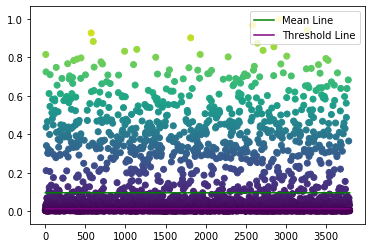

In [15]:
print_res(maxi,df_error,y_test)
print("Threshold")
print(maxi)
print("Mean")
print(mse.mean())

plt.scatter(range(mse.shape[0]),mse,c=mse)


plt.plot((range(mse.shape[0])),np.repeat(mse.mean(),mse.shape[0]),c='g',label='Mean Line')
plt.plot((range(mse.shape[0])),np.repeat(maxi,mse.shape[0]),c='purple',label='Threshold Line')

plt.legend(loc="upper right")


In [16]:
#deep autoencoder

encoded2 = Dense(round(X.shape[1]/1.5), activation='relu'
               #  ,activity_regularizer=regularizers.l1(1e-3)
                , kernel_regularizer=l2(0.01) 
               , bias_regularizer=l2(0.01)
                )(inputs)
encoded2 = Dense(round(X.shape[1]/3), activation='relu'
                # ,activity_regularizer=regularizers.l1(1e-3)
                 ,kernel_regularizer=l2(0.01)
                ,bias_regularizer=l2(0.01)
                )(encoded2)
#encoded2 = Dense(round(X.shape[1]/6), activation='relu')(encoded2)
encoded2 = Dense(3, activation='relu'
                ,activity_regularizer=regularizers.l1(1e-3)
                )(encoded2)

#decoded2 = Dense(round(X.shape[1]/6), activation='relu')(encoded2)
decoded2 = Dense(round(X.shape[1]/3), activation='relu'
               #  ,
                # kernel_regularizer=l2(0.01), 
               # bias_regularizer=l2(0.01)
                )(encoded2)
decoded2 = Dense(round(X.shape[1]/1.5), activation='relu'
               #  ,
               #  kernel_regularizer=l2(0.01), 
               # bias_regularizer=l2(0.01)
                )(decoded2)
decoded2 = Dense(X.shape[1], activation='tanh')(decoded2)

autoencoder2 = Model(inputs, decoded2)
autoencoder2.summary()
autoencoder2.compile(optimizer='adam', loss='mse')

autoencoder2.fit(X_train, X_train,
                epochs=epochs,
                batch_size=256,
                shuffle=False,
                callbacks=callbacks,
                validation_split=0.4
               )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                888       
_________________________________________________________________
dense_5 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 39        
_________________________________________________________________
dense_7 (Dense)              (None, 12)                48        
_________________________________________________________________
dense_8 (Dense)              (None, 24)                312       
_________________________________________________________________
dense_9 (Dense)              (None, 36)                900 

1583/1583 [==============================] - 0s 23us/sample - loss: 0.0286 - val_loss: 0.0280
Epoch 65/1000
1583/1583 [==============================] - 0s 23us/sample - loss: 0.0282 - val_loss: 0.0276
Epoch 66/1000
1583/1583 [==============================] - 0s 23us/sample - loss: 0.0278 - val_loss: 0.0272
Epoch 67/1000
1583/1583 [==============================] - 0s 25us/sample - loss: 0.0274 - val_loss: 0.0268
Epoch 68/1000
1583/1583 [==============================] - 0s 23us/sample - loss: 0.0271 - val_loss: 0.0265
Epoch 69/1000
1583/1583 [==============================] - 0s 25us/sample - loss: 0.0267 - val_loss: 0.0262
Epoch 70/1000
1583/1583 [==============================] - 0s 23us/sample - loss: 0.0264 - val_loss: 0.0259
Epoch 71/1000
1583/1583 [==============================] - 0s 23us/sample - loss: 0.0262 - val_loss: 0.0256
Epoch 72/1000
1583/1583 [==============================] - 0s 24us/sample - loss: 0.0259 - val_loss: 0.0254
Epoch 73/1000
1583/1583 [=================

1583/1583 [==============================] - 0s 29us/sample - loss: 0.0213 - val_loss: 0.0209
Epoch 140/1000
1583/1583 [==============================] - 0s 26us/sample - loss: 0.0213 - val_loss: 0.0209
Epoch 141/1000
1583/1583 [==============================] - 0s 25us/sample - loss: 0.0212 - val_loss: 0.0209
Epoch 142/1000
1583/1583 [==============================] - 0s 25us/sample - loss: 0.0212 - val_loss: 0.0208
Epoch 143/1000
1583/1583 [==============================] - 0s 25us/sample - loss: 0.0212 - val_loss: 0.0208
Epoch 144/1000
1583/1583 [==============================] - 0s 23us/sample - loss: 0.0212 - val_loss: 0.0208
Epoch 145/1000
1583/1583 [==============================] - 0s 26us/sample - loss: 0.0212 - val_loss: 0.0208
Epoch 146/1000
1583/1583 [==============================] - 0s 28us/sample - loss: 0.0211 - val_loss: 0.0208
Epoch 147/1000
1583/1583 [==============================] - 0s 25us/sample - loss: 0.0211 - val_loss: 0.0208
Epoch 148/1000
1583/1583 [========

1583/1583 [==============================] - 0s 23us/sample - loss: 0.0203 - val_loss: 0.0199
Epoch 215/1000
1583/1583 [==============================] - 0s 24us/sample - loss: 0.0203 - val_loss: 0.0199
Epoch 216/1000
1583/1583 [==============================] - 0s 25us/sample - loss: 0.0203 - val_loss: 0.0199
Epoch 217/1000
1583/1583 [==============================] - 0s 23us/sample - loss: 0.0203 - val_loss: 0.0199
Epoch 218/1000
1583/1583 [==============================] - 0s 23us/sample - loss: 0.0203 - val_loss: 0.0199
Epoch 219/1000
1583/1583 [==============================] - 0s 25us/sample - loss: 0.0203 - val_loss: 0.0199
Epoch 220/1000
1583/1583 [==============================] - 0s 23us/sample - loss: 0.0203 - val_loss: 0.0199
Epoch 221/1000
1583/1583 [==============================] - 0s 23us/sample - loss: 0.0203 - val_loss: 0.0199
Epoch 222/1000
1583/1583 [==============================] - 0s 23us/sample - loss: 0.0202 - val_loss: 0.0199
Epoch 223/1000
1583/1583 [========

In [17]:
#encoded_data = encoder.predict(test_x)
decoded_data2 = autoencoder2.predict(X_test)

#print(dict(zip(unique, counts)))
mse2 = np.mean(np.power(X_test - decoded_data2, 2), axis=1)

mse2 = mse2.reshape(-1, 1)
print(mse2.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
mse2 = scaler.fit_transform(mse2)
 

(3796, 1)


In [18]:
df_error2 = pd.DataFrame({'reconstruction_error': mse2[:,0]})
df_error2.describe()

,reconstruction_error
count,3796.000000
mean,0.099481
std,0.190600
min,0.000000
25%,0.004735
50%,0.014919
75%,0.052361
max,1.000000


In [19]:
if(df_error2.reconstruction_error.max()>2):
    maxi2 = find_max(calc_res,round(df_error2.reconstruction_error.max()/2),df_error2,y_test)
else:
    maxi2 = find_max(calc_res,df_error2.reconstruction_error.max(),df_error2,y_test)

#print(maxi)
#print(calc_res(maxi))


Iterations
46


Correct predictions
3273
Test Accuracy
0.8630382466503338
Number of Outliers found in Test
1541
Number of Outliers acutally in Test
2036
Outlier accuracy
0.7568762278978389
Number of Inliers found in Test
1732
Number of Inliers acutally in Test
1760
Inlier accuracy
0.9840909090909091
Number of Inliers classified as Outliers
523
Threshold
0.012
Mean
0.09948123425447723


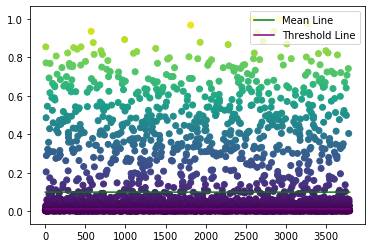

In [20]:
print_res(maxi2,df_error2,y_test)
print("Threshold")
print(maxi2)


print("Mean")
print(mse2.mean())

plt.scatter(range(mse2.shape[0]),mse2,c=mse2)

plt.plot((range(mse2.shape[0])),np.repeat(mse2.mean(),mse2.shape[0]),c='g',label='Mean Line')
plt.plot((range(mse2.shape[0])),np.repeat(maxi2,mse2.shape[0]),c='purple',label='Threshold Line')

plt.legend(loc="upper right")


In [21]:
def calc_res2(df_error,x,test_data):
    #taking the mean value of the reconstruction error as out seperation point for inliers and outliers
    outliers_array = df_error.index[df_error.reconstruction_error > x].tolist()
    test_y2 = test_data.to_numpy()
    #print(outliers2)
    accuracy_positive_count2 = 0
    accuracy_negative_count2 = 0
    for i in range(test_y2.shape[0]):
        if(test_y2[i] == 1):
            if(i in outliers_array[:]):
                accuracy_negative_count2 = accuracy_negative_count2 + 1
        else:
            if(not(i in outliers_array[:])):
                accuracy_positive_count2  = accuracy_positive_count2 + 1

#half of the test data is outliers and half inliers
    accuracy_positive2 = accuracy_positive_count2/(inliers_test)
    accuracy_negative2 = accuracy_negative_count2/(outliers_test)

    return accuracy_positive2
def calc_res3(df_error,x,test_data):
    #taking the mean value of the reconstruction error as out seperation point for inliers and outliers
    outliers_array = df_error.index[df_error.reconstruction_error > x].tolist()
    test_y2 = test_data.to_numpy()
    #print(outliers2)
    accuracy_positive_count2 = 0
    accuracy_negative_count2 = 0
    for i in range(test_y2.shape[0]):
        if(test_y2[i] == 1):
            if(i in outliers_array[:]):
                accuracy_negative_count2 = accuracy_negative_count2 + 1
        else:
            if(not(i in outliers_array[:])):
                accuracy_positive_count2  = accuracy_positive_count2 + 1

#half of the test data is outliers and half inliers
    accuracy_positive2 = accuracy_positive_count2/(inliers_test)
    accuracy_negative2 = accuracy_negative_count2/(outliers_test)

    return accuracy_negative2

In [22]:
# iii = np.arange(0,1,0.01)
# va = []
# for i in iii:
#     va.append(calc_res(df_error2,i,y_test))
    
# plt.plot(iii,np.array(va),label = 'Combined Accuracy')


# iii = np.arange(0,1,0.01)
# va2 = []
# for i in iii:
#     va2.append(calc_res2(df_error2,i,y_test))
    
# plt.plot(iii,np.array(va2),label = 'Inlier Accuracy')


# iii = np.arange(0,1,0.01)
# va3 = []
# for i in iii:
#     va3.append(calc_res3(df_error2,i,y_test))
    
# plt.plot(iii,np.array(va3),label = 'Outlier Accuracy')
# plt.plot(np.repeat(maxi2,iii.shape[0]),iii,c='purple',label='Threshold Line')
# plt.legend(loc="upper right")

In [23]:
# from sklearn.metrics import roc_curve
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, mse)
# from sklearn.metrics import auc
# auc_keras = auc(fpr_keras, tpr_keras)
# #print(thresholds_keras)
# print(auc_keras)
# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# #plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

# # Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# #plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

In [24]:
# from sklearn.metrics import roc_curve
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, mse2)
# from sklearn.metrics import auc
# auc_keras = auc(fpr_keras, tpr_keras)
# #print(thresholds_keras)
# print(auc_keras)
# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# #plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

# # Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# #plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

In [25]:
#deep autoencoder

encoded3 = Dense(round(X.shape[1]/1.3), activation='relu'
                # ,activity_regularizer=regularizers.l1(1e-3)
                 ,kernel_regularizer=l2(0.01)
                 ,bias_regularizer=l2(0.01)
                )(inputs)
encoded3 = Dense(round(X.shape[1]/2), activation='relu'
               #  ,activity_regularizer=regularizers.l1(1e-3)
                , kernel_regularizer=l2(0.01) 
                ,bias_regularizer=l2(0.01)
                )(encoded3)
encoded3 = Dense(round(X.shape[1]/2.8), activation='relu'
                 #,activity_regularizer=regularizers.l1(1e-3)
                , kernel_regularizer=l2(0.01) 
                ,bias_regularizer=l2(0.01)
                )(encoded3)
encoded3 = Dense(6, activation='relu'
#                  ,
#                  kernel_regularizer=l2(0.01), 
#                 bias_regularizer=l2(0.01)
                )(encoded3)

#decoded2 = Dense(80, activation='relu')(encoded2)
decoded3 = Dense(round(X.shape[1]/2.8), activation='relu'
               #  ,activity_regularizer=regularizers.l1(0.001)
               # , kernel_regularizer=l2(0.01), 
               # bias_regularizer=l2(0.01)
                )(encoded3)
decoded3 = Dense(round(X.shape[1]/2), activation='relu'
                # ,activity_regularizer=regularizers.l1(0.001)
               # , kernel_regularizer=l2(0.01), 
               # bias_regularizer=l2(0.01)
                )(decoded3)
decoded3 = Dense(round(X.shape[1]/1.3), activation='relu'
                # ,activity_regularizer=regularizers.l1(0.001)
               # , kernel_regularizer=l2(0.01), 
               # bias_regularizer=l2(0.01)
                )(decoded2)
decoded3 = Dense(X.shape[1], activation='tanh')(decoded3)

autoencoder3 = Model(inputs, decoded3)
autoencoder3.summary()
autoencoder3.compile(optimizer='adam', loss='mse')

autoencoder3.fit(X_train, X_train,
                epochs=epochs,
                batch_size=256,
                shuffle=False,
                callbacks=callbacks,
                validation_split=0.4
               )


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                888       
_________________________________________________________________
dense_5 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 39        
_________________________________________________________________
dense_7 (Dense)              (None, 12)                48        
_________________________________________________________________
dense_8 (Dense)              (None, 24)                312       
_________________________________________________________________
dense_9 (Dense)              (None, 36)                900 

(3796, 1)
Iterations
47
Correct predictions
3279
Test Accuracy
0.8640184256095584
Number of Outliers found in Test
1526
Number of Outliers acutally in Test
2036
Outlier accuracy
0.74950884086444
Number of Inliers found in Test
1753
Number of Inliers acutally in Test
1760
Inlier accuracy
0.9960227272727272
Number of Inliers classified as Outliers
517
Threshold
0.013999999999999997
Mean
0.10295045116514046


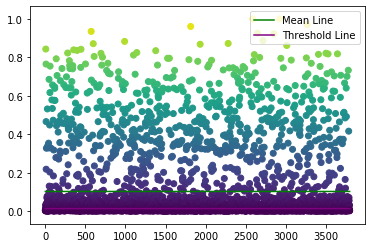

In [26]:
#encoded_data = encoder.predict(test_x)
decoded_data3 = autoencoder3.predict(X_test)

#print(dict(zip(unique, counts)))
mse3 = np.mean(np.power(X_test - decoded_data3, 2), axis=1)

mse3 = mse3.reshape(-1, 1)
print(mse3.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
mse3 = scaler.fit_transform(mse3)


df_error3 = pd.DataFrame({'reconstruction_error': mse3[:,0]})
df_error3.describe()

maxi3 = find_max(calc_res,df_error3.reconstruction_error.max(),df_error3,y_test)

#print(maxi)
#print(calc_res(maxi))
print_res(maxi3,df_error3,y_test)
print("Threshold")
print(maxi3)


print("Mean")
print(mse3.mean())

plt.scatter(range(mse3.shape[0]),mse3,c=mse3)


plt.plot((range(mse3.shape[0])),np.repeat(mse3.mean(),mse3.shape[0]),c='g',label='Mean Line')
plt.plot((range(mse3.shape[0])),np.repeat(maxi3,mse3.shape[0]),c='purple',label='Threshold Line')

plt.legend(loc="upper right")



Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36)]              0         
_________________________________________________________________
dense_18 (Dense)             (None, 34)                1258      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1120      
_________________________________________________________________
dense_20 (Dense)             (None, 30)                990       
_________________________________________________________________
dense_21 (Dense)             (None, 28)                868       
_________________________________________________________________
dense_22 (Dense)             (None, 26)                754       
_________________________________________________________________
dense_23 (Dense)             (None, 24)                648 

Epoch 53/500
1583/1583 [==============================] - 0s 38us/sample - loss: 0.0989 - val_loss: 0.0972
Epoch 54/500
1583/1583 [==============================] - 0s 41us/sample - loss: 0.0968 - val_loss: 0.0963
Epoch 55/500
1583/1583 [==============================] - 0s 35us/sample - loss: 0.0943 - val_loss: 0.0914
Epoch 56/500
1583/1583 [==============================] - 0s 37us/sample - loss: 0.0917 - val_loss: 0.0914
Epoch 57/500
1583/1583 [==============================] - 0s 37us/sample - loss: 0.0898 - val_loss: 0.0908
Epoch 58/500
1583/1583 [==============================] - 0s 33us/sample - loss: 0.0878 - val_loss: 0.0850
Epoch 59/500
1583/1583 [==============================] - 0s 33us/sample - loss: 0.0850 - val_loss: 0.0842
Epoch 60/500
1583/1583 [==============================] - 0s 38us/sample - loss: 0.0832 - val_loss: 0.0814
Epoch 61/500
1583/1583 [==============================] - 0s 38us/sample - loss: 0.0805 - val_loss: 0.0838
Epoch 62/500
1583/1583 [=============

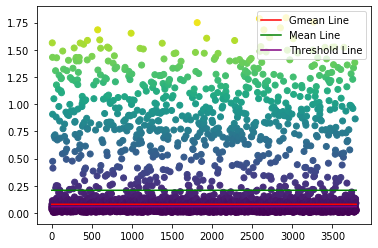

In [27]:
# #deep autoencoder
if(X.shape[1]>14):
    encoded4 = Dense(round(X.shape[1]-2), activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                     ,kernel_regularizer=l2(0.01)
                     ,bias_regularizer=l2(0.1)
                    )(inputs)
    encoded4 = Dense(round(X.shape[1]-4), activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(0.01) 
                    ,bias_regularizer=l2(0.1)
                    )(encoded4)
    encoded4 = Dense(round(X.shape[1]-6), activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(0.01) 
                    ,bias_regularizer=l2(0.1)
                    )(encoded4)
    encoded4 = Dense(round(X.shape[1]-8), activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(0.01) 
                    ,bias_regularizer=l2(0.1)
                    )(encoded4)
    encoded4 = Dense(round(X.shape[1]-10), activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(0.01) 
                    ,bias_regularizer=l2(0.1)
                    )(encoded4)
    encoded4 = Dense(round(X.shape[1]-12), activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(0.01) 
                    ,bias_regularizer=l2(0.1)
                    )(encoded4)
    encoded4 = Dense(round(X.shape[1]-14), activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(0.01) 
                    ,bias_regularizer=l2(0.1)
                    )(encoded4)
    encoded4 = Dense(5, activation='relu'
    #                  ,
    #                  kernel_regularizer=l2(0.01), 
    #                 bias_regularizer=l2(0.01)
                    )(encoded4)

    #decoded2 = Dense(80, activation='relu')(encoded2)
    decoded4 = Dense(round(X.shape[1]-14), activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(0.01), 
                   # bias_regularizer=l2(0.01)
                    )(encoded4)
    decoded4 = Dense(round(X.shape[1]-12), activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(0.01), 
                   # bias_regularizer=l2(0.01)
                    )(decoded4)
    decoded4 = Dense(round(X.shape[1]-10), activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(0.01), 
                   # bias_regularizer=l2(0.01)
                    )(decoded4)

    decoded4 = Dense(round(X.shape[1]-8), activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(0.01), 
                   # bias_regularizer=l2(0.01)
                    )(decoded4)                 
    decoded4 = Dense(round(X.shape[1]-6), activation='relu'
                    # ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(0.01), 
                   # bias_regularizer=l2(0.01)
                    )(decoded4)

    decoded4 = Dense(round(X.shape[1]-4), activation='relu'
                    # ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(0.01), 
                   # bias_regularizer=l2(0.01)
                    )(decoded4)
    decoded4 = Dense(round(X.shape[1]-2), activation='relu'
                    # ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(0.01), 
                   # bias_regularizer=l2(0.01)
                    )(decoded4)
    decoded4 = Dense(X.shape[1], activation='tanh')(decoded4)

    autoencoder4 = Model(inputs, decoded4)
    autoencoder4.summary()
    autoencoder4.compile(optimizer='adam', loss='mse')

    autoencoder4.fit(X_train, X_train,
                    epochs=500,
                    batch_size=256,
                    shuffle=True,
                    callbacks=callbacks,
                    validation_split=0.4
                   )
#encoded_data = encoder.predict(test_x)
try:
    autoencoder4
except NameError:
    print("well, autoencoder4 WASN'T defined after all!")
else:
    print("sure, it was defined.")
    decoded_data4 = autoencoder4.predict(X_test)
    print (decoded_data4)
    #print(dict(zip(unique, counts)))
    mse4 = np.mean(np.power(X_test - decoded_data4, 2), axis=1)
    df_error4 = pd.DataFrame({'reconstruction_error': mse4})
    df_error4.describe()

    maxi4 = find_max(calc_res,df_error4.reconstruction_error.max(),df_error4,y_test)

    #print(maxi)
    #print(calc_res(maxi))
    print_res(maxi4,df_error4,y_test)
    print("Threshold")
    print(maxi4)


    print("Mean")
    print(mse4.mean())
    print("Gmean")
    print(gmean(mse4))
    plt.scatter(range(mse4.shape[0]),mse4,c=mse4)

    plt.plot((range(mse4.shape[0])),np.repeat(gmean(mse4),mse4.shape[0]),c='r',label='Gmean Line')
    plt.plot((range(mse4.shape[0])),np.repeat(mse4.mean(),mse4.shape[0]),c='g',label='Mean Line')
    plt.plot((range(mse4.shape[0])),np.repeat(maxi4,mse4.shape[0]),c='purple',label='Threshold Line')

    plt.legend(loc="upper right")

    y_pred_bool4 = np.argmax(decoded_data4, axis=1)
    #print(classification_report(y_test, y_pred_bool4))

In [28]:
ensemble = [];
#print(mse3[1])
try:
    mse4
except NameError:
    print("well, it WASN'T defined after all!")
    for i in range(0,mse.size):
        ensemble.append(0.333*mse[i][0]+0.333*mse2[i][0]+0.333*mse3[i])
else:
    print("sure, it was defined.")
    for i in range(0,mse.size):
        ensemble.append(0.25*mse[i][0]+0.25*mse2[i][0]+0.25*mse3[i] +0.25*mse4[i])

#print(ensemble)

sure, it was defined.


In [29]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
try:
    mse4
except NameError:
    print("well, it WASN'T defined after all!")
    x = concatenate([decoded, decoded2,decoded3])  # merge the outputs of the two models
else:
    print("sure, it was defined.")
    x = concatenate([decoded, decoded2,decoded3,decoded4])  # merge the outputs of the two models


out = Dense(X.shape[1],activation='tanh')(x)  # final layer of the network
model = Model(inputs=inputs, outputs=out)

model.summary()
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, X_train,
                epochs=500,
                batch_size=256,
                shuffle=True,
                callbacks=callbacks,
                validation_split=0.4
               )

ensemble_pred = model.predict(X_test)
print(ensemble_pred)
ensemble2_mse = np.mean(np.power(X_test - ensemble_pred, 2), axis=1)

sure, it was defined.
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 34)           1258        input_1[0][0]                    
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 32)           1120        dense_18[0][0]                   
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 30)           990         dense_19[0][0]                   
______________________________________________________________________

1583/1583 [==============================] - 0s 63us/sample - loss: 0.0319 - val_loss: 0.0309
Epoch 13/500
1583/1583 [==============================] - 0s 54us/sample - loss: 0.0302 - val_loss: 0.0285
Epoch 14/500
1583/1583 [==============================] - 0s 54us/sample - loss: 0.0282 - val_loss: 0.0269
Epoch 15/500
1583/1583 [==============================] - 0s 51us/sample - loss: 0.0267 - val_loss: 0.0254
Epoch 16/500
1583/1583 [==============================] - 0s 49us/sample - loss: 0.0253 - val_loss: 0.0241
Epoch 17/500
1583/1583 [==============================] - 0s 52us/sample - loss: 0.0240 - val_loss: 0.0228
Epoch 18/500
1583/1583 [==============================] - 0s 52us/sample - loss: 0.0228 - val_loss: 0.0220
Epoch 19/500
1583/1583 [==============================] - 0s 53us/sample - loss: 0.0218 - val_loss: 0.0208
Epoch 20/500
1583/1583 [==============================] - 0s 56us/sample - loss: 0.0208 - val_loss: 0.0198
Epoch 21/500
1583/1583 [==========================

sure, it was defined.
Model 1
0.8101940636720842
Model 2
0.7959289605286659
Model 3
0.7963796548490801
Model 4
Ensemble
0.8233716400250045
Ensemble2
0.8348756474370422
sure, it was defined.


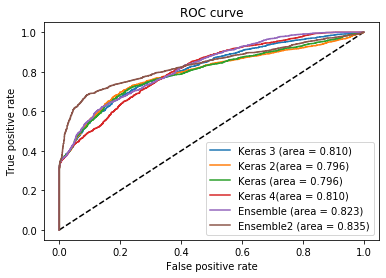

sure, it was defined.


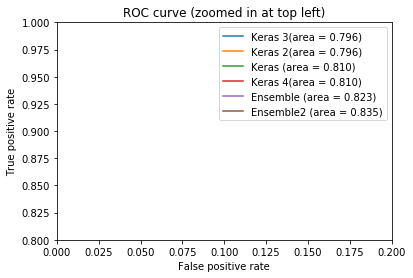

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr_keras3, tpr_keras3, thresholds_keras3 = roc_curve(y_test, mse3)
fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(y_test, mse2)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, mse)
fpr_keras5, tpr_keras5, thresholds_keras5 = roc_curve(y_test, ensemble2_mse)

try:
    mse4
except NameError:
    print("well, it WASN'T defined after all!")
else:
    print("sure, it was defined.")
    fpr_keras4, tpr_keras4, thresholds_keras4 = roc_curve(y_test, mse4)
    auc_keras4 = auc(fpr_keras4, tpr_keras4)

fpr_kerasE, tpr_kerasE, thresholds_kerasE = roc_curve(y_test, ensemble)

#print(thresholds_keras2)


auc_keras = auc(fpr_keras, tpr_keras)
auc_keras2 = auc(fpr_keras2, tpr_keras2)
auc_keras3 = auc(fpr_keras3, tpr_keras3)

auc_kerasE = auc(fpr_kerasE, tpr_kerasE)
auc_keras5 = auc(fpr_keras5, tpr_keras5)


#print(thresholds_keras)
print('Model 1')
print(auc_keras)
print('Model 2')
print(auc_keras2)
print('Model 3')
print(auc_keras3)
print('Model 4')
#print(auc_keras4)
print('Ensemble')
print(auc_kerasE)
print('Ensemble2')
print(auc_keras5)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras 3 (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras2, tpr_keras2, label='Keras 2(area = {:.3f})'.format(auc_keras2))
plt.plot(fpr_keras3, tpr_keras3, label='Keras (area = {:.3f})'.format(auc_keras3))
try:
    mse4
except NameError:
    print("well, it WASN'T defined after all!")
else:
    print("sure, it was defined.")
    plt.plot(fpr_keras4, tpr_keras4, label='Keras 4(area = {:.3f})'.format(auc_keras4))
plt.plot(fpr_kerasE, tpr_kerasE, label='Ensemble (area = {:.3f})'.format(auc_kerasE))
plt.plot(fpr_keras5, tpr_keras5, label='Ensemble2 (area = {:.3f})'.format(auc_keras5))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras 3(area = {:.3f})'.format(auc_keras3))
plt.plot(fpr_keras2, tpr_keras2, label='Keras 2(area = {:.3f})'.format(auc_keras2))
plt.plot(fpr_keras3, tpr_keras3, label='Keras (area = {:.3f})'.format(auc_keras))
try:
    mse4
except NameError:
    print("well, it WASN'T defined after all!")
else:
    print("sure, it was defined.")
    plt.plot(fpr_keras4, tpr_keras4, label='Keras 4(area = {:.3f})'.format(auc_keras4))
plt.plot(fpr_kerasE, tpr_kerasE, label='Ensemble (area = {:.3f})'.format(auc_kerasE))
plt.plot(fpr_keras5, tpr_keras5, label='Ensemble2 (area = {:.3f})'.format(auc_keras5))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

593    0.014219
Name: threshold, dtype: float64


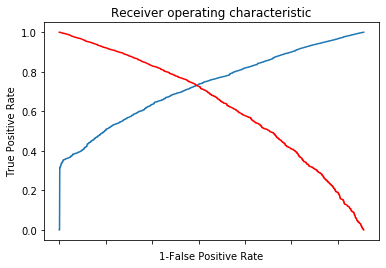

In [31]:
i = np.arange(len(tpr_keras)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_keras, index=i),'tpr' : pd.Series(tpr_keras, index = i), '1-fpr' : pd.Series(1-fpr_keras, index = i), 'tf' : pd.Series(tpr_keras - (1-fpr_keras), index = i), 'thresholds' : pd.Series(thresholds_keras, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]


# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

roc = pd.DataFrame({'tf' : pd.Series(tpr_keras-(1-fpr_keras), index=i), 'threshold' : pd.Series(thresholds_keras, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
#list(roc_t['threshold'])
threshold1 = roc_t['threshold']
print(threshold1)
threshold1 = threshold1.to_numpy()
threshold1 = threshold1[0]

569    0.013528
Name: threshold, dtype: float64


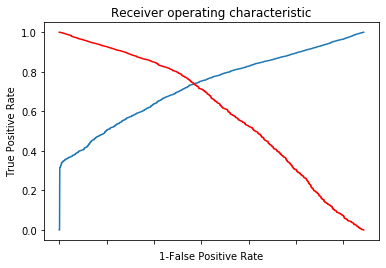

In [32]:
i = np.arange(len(tpr_keras2)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_keras2, index=i),'tpr' : pd.Series(tpr_keras2, index = i), '1-fpr' : pd.Series(1-fpr_keras2, index = i), 'tf' : pd.Series(tpr_keras2 - (1-fpr_keras2), index = i), 'thresholds' : pd.Series(thresholds_keras2, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]


# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

roc = pd.DataFrame({'tf' : pd.Series(tpr_keras2-(1-fpr_keras2), index=i), 'threshold' : pd.Series(thresholds_keras2, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
list(roc_t['threshold'])
threshold2 = roc_t['threshold']
print(threshold2)
threshold2 = threshold2.to_numpy()
threshold2 = threshold2[0]

560    0.015592
Name: threshold, dtype: float64


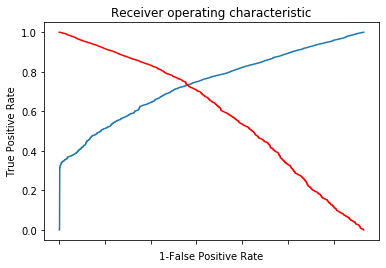

In [33]:
i = np.arange(len(tpr_keras3)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_keras3, index=i),'tpr' : pd.Series(tpr_keras3, index = i), '1-fpr' : pd.Series(1-fpr_keras3, index = i), 'tf' : pd.Series(tpr_keras3 - (1-fpr_keras3), index = i), 'thresholds' : pd.Series(thresholds_keras3, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]


# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

roc = pd.DataFrame({'tf' : pd.Series(tpr_keras3-(1-fpr_keras3), index=i), 'threshold' : pd.Series(thresholds_keras3, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
list(roc_t['threshold'])
threshold3 = roc_t['threshold']
print(threshold3)
threshold3 = threshold3.to_numpy()
threshold3 = threshold3[0]

In [34]:
#ensemble

result1 = [];
result2 = [];
result3 = [];

print(threshold1)
for i in range(0,mse.size):
    if(mse[i][0]>threshold1):
        result1.append(1);
    else:
        result1.append(0);
    if(mse2[i][0]>threshold2):
        result2.append(1);
    else:
        result2.append(0);
    if(mse3[i]>threshold3):
        result3.append(1);
    else:
        result3.append(0);

correct =0; 
correct2 =0; 
correct3 =0; 
correct4 =0;
for i in range(0,mse.size):
    if(result1[i] == y_test.to_numpy()[i]):
        correct = correct + 1;
print(correct/mse.size)

for i in range(0,mse.size):
    if(result2[i] == y_test.to_numpy()[i]):
        correct2 = correct2 + 1;
print(correct2/mse.size)


for i in range(0,mse.size):
    if(result3[i] == y_test.to_numpy()[i]):
        correct3 = correct3 + 1;
print(correct3/mse.size)

for i in range(0,mse.size):
    temp = (result1[i] + result2[i] + result3[i] )/3
    if(temp>0.5):
        if(1 == y_test.to_numpy()[i]):
            correct4 = correct4 + 1;
    else:
        if(0 == y_test.to_numpy()[i]):
            correct4 = correct4 + 1;
        
print(correct4/mse.size)


0.014219288982506234
0.7302423603793466
0.738145416227608
0.7341938883034773
0.7360379346680717
